In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import os
import cv2
from glob import glob

from pathlib import Path
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import PIL

import torch.backends.cudnn as cudnn
from sklearn.metrics import roc_auc_score

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms

import torch.optim as optim
import time

In [3]:
# print()
os.chdir(os.path.join(os.getcwd()+'/gdrive/MyDrive/cxr8'))
!ls

ARXIV_V5_CHESTXRAY.pdf	   images_003  LOG_CHESTXRAY.pdf
BBox_List_2017.csv	   images_004  __pycache__
Data_Entry_2017.csv	   images_005  README_CHESTXRAY.pdf
FAQ_CHESTXRAY.pdf	   images_006  second_train_model.pth
first_train_model.pth	   images_007  test_file.txt
first_train_model.pth.tar  images_008  test_list.txt
helper.py		   images_009  train_file.txt
image_path_label_df.csv    images_010  train_val_list.txt
images_001		   images_011
images_002		   images_012


# Create main image dataset

In [4]:
pathology_list = ['Cardiomegaly', 'Emphysema', 'Effusion', 'Hernia', 'Nodule', 'Pneumothorax', 'Atelectasis',
                    'Pleural_Thickening', 'Mass','Edema', 'Consolidation', 'Infiltration', 'Fibrosis', 'Pneumonia',
                  'No Findings']

n_classes = len(pathology_list)

In [21]:
def image_label():

  """
  Description : Get the labels of the chest x-rays in column/wide format and drop all irrelevant columns
  input : None
  output : A dataframe containing the image and it's classes as columns with 1-hot encoded values
  """

  # Read the main csv contianing images and classes
  labels = pd.read_csv('Data_Entry_2017.csv')

  # multi hot encoding
  for pathology in pathology_list :
      labels [pathology] = labels ['Finding Labels'].apply (lambda x: 1 if pathology in x else 0)

  labels ['No Findings'] = labels ['Finding Labels'].apply (lambda x: 1 if 'No Finding' in x else 0)

  print('Total Unique Patients ',labels['Patient ID'].nunique())
  print('Total images ', labels['Image Index'].nunique(), '\n')

  # Drop the irrelevant columns

  labels = labels.drop (list (labels.iloc [:,1:12].columns.values), axis = 1)

  return labels

In [ ]:
def image_path_label(image_df):

  """
  Description :
  1. Read the path of the images
  2. Drop the images for which no path is found
  input : A dataframe contianing the image name and its classes
  output : A dataframe containing the image name, image path and its classes
  """

  start_time = datetime.datetime.now()

  all_image_paths = []
  path = os.getcwd()

  # Parse through all the image folders
  for folder in Path(path).glob('images_*'):
    all_image_paths += list(folder.glob('images/*.png'))

  end_time = datetime.datetime.now()

  # Convert the image paths to dictionary
  all_image_paths_dict = {path.parts[-1]: path for path in all_image_paths}

  # Map the dictionary of image's path to the image name
  image_df['path'] = image_df['Image Index'].map(all_image_paths_dict.get)

  print('Total time taken to read the path of all images is ', (end_time - start_time).seconds, ' seconds')

  print('Saving the dataframe to the pwd')
  image_df.to_csv('image_path_label_df.csv')

  print('\nTotal images with path available', image_df[image_df.path.notna()].shape[0])
  print('Total images with path not available', image_df[image_df.path.isna()].shape[0])

  # Dropping the images where image name is available but image path not available
  print('\nDropping the images where image path not available')
  image_df = image_df[image_df.path.notna()]

  return image_df

In [93]:
if os.path.exists('./image_path_label_df.csv'):
  print('File already exists in directory. Fetching from directory')

  image_label_df = pd.read_csv('image_path_label_df.csv')

  print('\nTotal images with path available', image_label_df[image_label_df.path.notna()].shape[0])
  print('Total images with path not available', image_label_df[image_label_df.path.isna()].shape[0])

  # Dropping the images where image name is available but image path not available
  print('\nDropping the images where image path not available')
  image_label_df = image_label_df[image_label_df.path.notna()]
  image_label_df.drop(columns=image_label_df.columns[0], axis=1,  inplace=True)

else:
  image_label_df = image_path_label(image_label())

image_label_df.head()

File already exists in directory. Fetching from directory

Total images with path available 111837
Total images with path not available 283

Dropping the images where image path not available


,Image Index,Cardiomegaly,Emphysema,Effusion,Hernia,Nodule,Pneumothorax,Atelectasis,Pleural_Thickening,Mass,Edema,Consolidation,Infiltration,Fibrosis,Pneumonia,No Findings,path
0,00000001_000.png,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,/content/gdrive/MyDrive/cxr8/images_001/images...
1,00000001_001.png,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,/content/gdrive/MyDrive/cxr8/images_001/images...
2,00000001_002.png,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,/content/gdrive/MyDrive/cxr8/images_001/images...
3,00000002_000.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,/content/gdrive/MyDrive/cxr8/images_001/images...
4,00000003_000.png,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,/content/gdrive/MyDrive/cxr8/images_001/images...


# Create train and test dataloaders

In [94]:
def train_test_split(split_type, image_path_df):

  """
  input :
    1. split_type : type of split - train or test
    2. image_path_df : dataframe containing image name, path and classes
  output : train or test dataframe depending on split_type
  """

  if split_type == 'train':
    split_type = 'train_val_list.txt'
  elif split_type == 'test':
    split_type = 'test_list.txt'
  else:
    print('Invalid split')
    return 0

  dataset_list = pd.read_csv(split_type, names = ['images'])

  final_df = pd.merge(image_path_df, dataset_list, left_on = 'Image Index', right_on = 'images', how = 'inner').drop(['Image Index', 'images'], axis = 1)

  print(f"{split_type.split('.')[0].split('_')[0]} dataframe has {final_df.shape[0]} images")

  return final_df

In [95]:
train_df = train_test_split('train', image_label_df)
test_df = train_test_split('test', image_label_df)

train dataframe has 86306 images
test dataframe has 25531 images


In [96]:
# Class to read the image path

class ChestXrayDataSet(Dataset):
    def __init__(self, image_list_file, transform=None):
        """
        Args:
            image_list_file: path to the file containing images
                with corresponding labels.
            transform: optional transform to be applied on a sample.
        """
        image_names = []
        labels = []
        with open(image_list_file, "r") as f:
            for line in f:
                items = line.split()
                image_name = items[-1]
                label = items[0:-1]
                label = [int(i) for i in label]
                image_names.append(image_name)
                labels.append(label)

        self.image_names = image_names
        self.labels = labels
        self.transform = transform

    def __getitem__(self, index):
        """
        Args:
            index: the index of item

        Returns:
            image and its labels
        """
        image_name = self.image_names[index]
        image = PIL.Image.open(image_name).convert('RGB')
        label = self.labels[index]
        if self.transform is not None:
            image = self.transform(image)
        return image, torch.FloatTensor(label)

    def __len__(self):
        return len(self.image_names)

In [97]:
# Create train and test dataset

def dataloader(split_type, custom_batch_size):

  # Recenter and rescale the data near 0 mean and 1 standard deviation
  # formula -> h(activation) = (h(i) - m(h))/(s(h) - ê)
  # symbols in bracket are subscripts
  # m - empirical mean
  # s - empirical standard deviation
  # ê - very small scalar to avoid division by 0

  normalize = transforms.Normalize(
      [0.485, 0.456, 0.406],
      [0.229, 0.224, 0.225])

  dataset_transform = transforms.Compose([transforms.Resize(256),
                                    transforms.TenCrop(224),
                                    transforms.Lambda
                                    (lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])),
                                    transforms.Lambda
                                    (lambda crops: torch.stack([normalize(crop) for crop in crops]))
                                    # transforms.ToTensor(),
                                    # transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                                  ])

  dataset = ChestXrayDataSet(image_list_file = f"{os.getcwd()}/{split_type}_file.txt",
                                  transform = dataset_transform)

  dataloader = torch.utils.data.DataLoader(dataset,
                                           batch_size = custom_batch_size,
                                           shuffle=False,
                                           num_workers = 2,
                                           pin_memory = True)

  return dataloader

# Visualize

In [98]:
def dataset_analysis(split_type):
  split_dict = dict()
  for class_name in pathology_list:
    if split_type == 'train':
      split_dict[class_name] = train_df[class_name].sum()
    else:
      split_dict[class_name] = test_df[class_name].sum()

  return split_dict

def common_entries(*dcts):
  if not dcts:
      return
  for i in set(dcts[0]).intersection(*dcts[1:]):
      yield (i,) + tuple(d[i] for d in dcts)

def visualise():

  train_analysis = dataset_analysis(split_type = 'train')
  test_analysis = dataset_analysis(split_type = 'test')

  final_train_test_contri = list(common_entries(train_analysis, test_analysis))

  temp = pd.DataFrame(final_train_test_contri,
                      columns = ['pathology','train','test'])
  temp.set_index('pathology', inplace = True)

  ax = temp.plot.bar(rot = 90, subplots = True, figsize = (7,5))


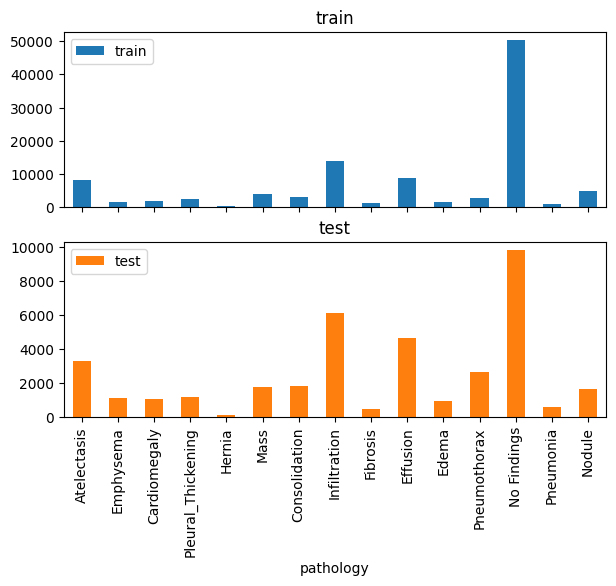

In [99]:
# Visualize the whole train and test split

visualise()

In [ ]:
def custom_imshow(image, title=None):
    """Imshow for Tensor."""
    image = image.numpy().transpose((1, 2, 0))

    mean = 0.5 # np.array([0.485, 0.456, 0.406])
    std = 0.5 # np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)

    return image
    # fig=plt.figure(figsize=(10, 5))

    # if title:
    #   plt.title(title)

    # columns = 4; rows = 2

    # for i in range(1, columns*rows +1):
    #     fig.add_subplot(rows, columns, i)
    #     plt.imshow(image)
    #     plt.axis(False)
    #     fig.add_subplot


In [ ]:
image, label = next(iter(train_dataloader))
# custom_imshow(image[1], normalize = True, title = 'Image')
# img = torchvision.utils.make_grid(image, nrow = 8)
# custom_imshow(image[0][0], 'Random Batch of Images')

fig=plt.figure(figsize=(10, 5))
columns = 4; rows = 2
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(custom_imshow(image[0][i-1]))
    plt.title(pathology_df[pathology_df['class'] == label[i-1].item()].loc[label[i-1].item()].label)
    plt.axis(False)
    fig.add_subplot

In [13]:
for i, (inp, label) in enumerate(train_dataloader):
  print('Input tensor shape ->', inp.shape)
  print('Label tensor shape ->',label.shape)
  # print('\nExample input tensor ->', inp)
  # print('Example label tensor ->',label[:5])
  break

KeyboardInterrupt: ignored

# Methodology

In [100]:
# Temporary for testing purposes

train_df = train_df[:10000]
test_df = test_df[:500]

print('Temporary train_df', train_df.shape)
print('Temporary test_df', test_df.shape)

Temporary train_df (10000, 16)
Temporary test_df (500, 16)


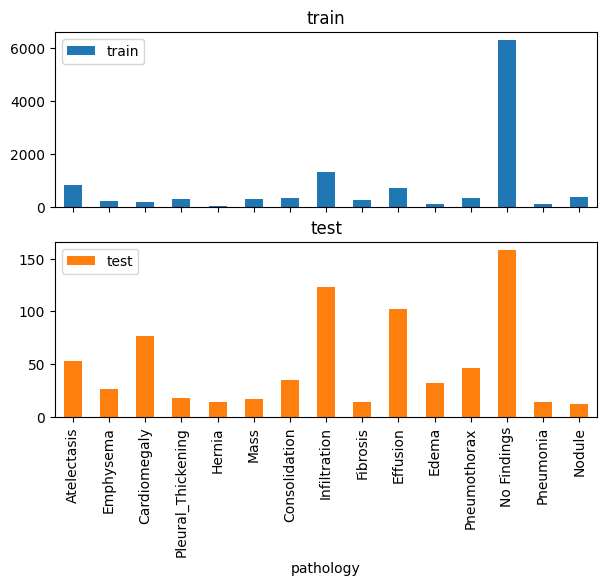

In [101]:
# New train and test split

visualise()

In [102]:
# Saving the train and test dataframe to text file

# Save the train dataframe
if os.path.exists('./train_file.txt'):
  os.remove('./train_file.txt')
  train_df.to_csv(r'./train_file.txt', header=None, index=None, sep=' ', mode='a')
else:
  train_df.to_csv(r'./train_file.txt', header=None, index=None, sep=' ', mode='a')

if os.path.exists('./test_file.txt'):
  os.remove('./test_file.txt')
  test_df.to_csv(r'./test_file.txt', header=None, index=None, sep=' ', mode='a')
else:
  test_df.to_csv(r'./test_file.txt', header=None, index=None, sep=' ', mode='a')

In [103]:
train_dataloader = dataloader('train', 32)
test_dataloader = dataloader('test', 32)

# Model

In [104]:
def model_definition(model, gradient_req):
  model = torchvision.models.densenet121()

  if gradient_req == 'baseline_test' or gradient_req == 'classifier':
    for param in model.parameters():
      if gradient_req == 'baseline_test' or gradient_req == 'classifier':
        param.requires_grad = False
      elif gradient_req == 'full_model':
        param.requires_grad = True
      else:
        print('Wrong model training parameters')

  num_ftrs = model.classifier.in_features

  model.classifier = nn.Sequential(
      nn.Linear(num_ftrs, n_classes),
      nn.Sigmoid()
  )

  return model

# Testing

In [105]:
# Calculate AUC ROC score

def compute_roc_auc(y_true, y_pred):
  y_true_np = y_true.cpu().numpy()
  y_pred_np = y_pred.cpu().numpy()
  AUCROC = []

  for i in range(n_classes):
      AUCROC.append(roc_auc_score(y_true_np[:, i], y_pred_np[:, i]))
  return AUCROC

In [106]:
def model_testing(mode, version = None):

  # initialize and load the model. Use this for testing without training the model
  if mode == 'baseline_test':
    model = model_definition(torchvision.models.densenet121(), gradient_req = 'baseline_test')
    model = model.cuda()

  # Use this for testing after training the model
  # model = train_model
  if mode == 'train_classifier' or mode == 'train_model':
    if mode == 'train_classifier':
      version = 'first'
    else:
      version = 'second'
    model = model_definition(torchvision.models.densenet121(), gradient_req = 'baseline_test')
    model.load_state_dict(torch.load(f'{version}_train_model.pth'))
    model = model.cuda()
    model.eval()

  y_true = torch.FloatTensor()
  y_true = y_true.cuda()
  y_pred = torch.FloatTensor()
  y_pred = y_pred.cuda()

  # with torch.no_grad():
  for i, (inp, target) in enumerate(test_dataloader):

    # print(i,'\ninput shape', inp.shape)

    target = target.cuda() # Y
    # inp = inp.cuda()
    y_true = torch.cat((y_true, target), 0)

    # print(f"Memory allocated: {torch.cuda.memory_allocated() // 10**9}")

    bs, n_crops, c, h, w = inp.shape
    inp = inp.view(-1, c, h, w).cuda()

    output = model(inp)
    output = output.view(bs, n_crops, -1)

    output_mean = output.mean(1)
    y_pred = torch.cat((y_pred, output_mean.data), 0) # Y^

    # print('y_true ',y_true.shape)
    # print('y_pred ',y_pred.shape)

    # print(f"Memory allocated: {torch.cuda.memory_allocated() // 10**9}")
    torch.cuda.empty_cache()
    # print(f"Memory allocated: {torch.cuda.memory_allocated() // 10**9}\n")

  return y_true, y_pred


In [112]:
auroc_dict = dict()

def method_roc_auc_score(mode):
  y_true, y_pred = model_testing(mode = mode)

  aurocIndividual = compute_roc_auc(y_true, y_pred)
  aurocMean = np.array(aurocIndividual).mean()

  print ('\nAUROC mean ', round(aurocMean,3),'\n')

  for i in range (0, len(aurocIndividual)):
    print (pathology_list[i], ' - ', round(aurocIndividual[i],3))

  auroc_dict[mode] = aurocIndividual

  return aurocIndividual, aurocMean

In [115]:
aurocIndividual, aurocMean = method_roc_auc_score(mode = 'baseline_test')


AUROC mean  0.512 

Cardiomegaly  -  0.49
Emphysema  -  0.457
Effusion  -  0.452
Hernia  -  0.855
Nodule  -  0.613
Pneumothorax  -  0.543
Atelectasis  -  0.568
Pleural_Thickening  -  0.433
Mass  -  0.509
Edema  -  0.506
Consolidation  -  0.428
Infiltration  -  0.514
Fibrosis  -  0.31
Pneumonia  -  0.466
No Findings  -  0.534


# Training

In [24]:
def tile(a, dim, n_tile):
  """
  input
  a - label matrix of size (batch_size x n_classes)
  dim - 0
  n_tile - number of copies for a single image label

  output
  return matrix of size (batch_size * n_tile x n_classes)
  """
    init_dim = a.size(dim)
    repeat_idx = [1] * a.dim()
    repeat_idx[dim] = n_tile
    a = a.repeat(*(repeat_idx))
    order_index = torch.LongTensor(np.concatenate([init_dim * np.arange(n_tile) + i for i in range(init_dim)]))
    return torch.index_select(a, dim, order_index)

In [ ]:
  # %%time
def model_train(model, optimizer, loss_fn, epochs):
  """
  input
  model - model definition
  optimizer - choice of optimizer
  loss_fn - choice of loss function/criterion
  epochs - number of time to run the training loop

  output - trains the model
  """

    for epoch in range(epochs):  # loop over the dataset multiple times

      running_loss = 0.0
      print('Epoch',epoch+1,'\n')

      for i, (inp, label) in enumerate(train_dataloader, 0): # get the inputs; data is a list of [images, labels]

        #inp.shape -> [16, 10, 3, 224, 224]
        #label.shape -> [16, 15]
        print('Iteration',i+1)

        # zero the parameter gradients
        optimizer.zero_grad()

        #format input
        # bs, n_crops, c, h, w = inp.shape
        # inp = inp.view(-1, c, h, w).cuda()
        # label = tile(label, 0, 10)
        inp = inp.cuda(non_blocking = True)
        label = label.cuda(non_blocking = True)

        # forward + backward + optimize
        # print('Input shape', inp.shape)
        # print('Label shape', label.shape)
        output = model(inp)

        loss = loss_fn(output, label)

        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        print('Running loss', running_loss, '\n')

        if i % 100 == 99:    # print every 100 mini-batches
          print(f"[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.3f}")
          running_loss = 0.0

      print('\n')

    if scheduler: scheduler.step()

    print('Finished Training')

In [ ]:
# Number of epochs
epochs = 5

# Loss function and optimizer
loss_fn = nn.BCELoss()
optimizer = optim.Adam(model.classifier.parameters(), lr = 0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-5)

In [ ]:
# Training the parameters of the classifier layer of the model

model = model_definition(torchvision.models.densenet121(), gradient_req = 'classifier')
model = model.cuda()

start = time.time()
model_train(model = model, optimizer = optimizer, loss_fn = loss_fn, epochs = epochs)
end = time.time()

torch.save(model.state_dict(), './first_train_model.pth')

print('Time taken',(end - start)/60,' minutes')

In [113]:
aurocIndividual, aurocMean = method_roc_auc_score(mode = 'train_classifier')


AUROC mean  0.531 

Cardiomegaly  -  0.451
Emphysema  -  0.481
Effusion  -  0.429
Hernia  -  0.265
Nodule  -  0.457
Pneumothorax  -  0.745
Atelectasis  -  0.589
Pleural_Thickening  -  0.578
Mass  -  0.726
Edema  -  0.521
Consolidation  -  0.486
Infiltration  -  0.548
Fibrosis  -  0.776
Pneumonia  -  0.44
No Findings  -  0.479


In [ ]:
# Training the parameters of the whole model

model = model_definition(torchvision.models.densenet121(), gradient_req = 'full_model')
model = model.cuda()

start = time.time()
model_train(model, optimizer, loss_fn, epochs)
end = time.time()

torch.save(model.state_dict(), './second_train_model.pth')

print('Time taken',(end - start)/60,' minutes')

Model state before training OrderedDict([('0.weight', tensor([[ 0.0299,  0.0261, -0.0296,  ...,  0.0056, -0.0255, -0.0154],
        [-0.0163,  0.0212,  0.0041,  ...,  0.0254,  0.0243,  0.0193],
        [ 0.0012, -0.0132, -0.0138,  ...,  0.0126,  0.0308,  0.0197],
        ...,
        [-0.0115,  0.0300, -0.0038,  ...,  0.0266,  0.0192, -0.0137],
        [-0.0131, -0.0264, -0.0056,  ..., -0.0278, -0.0054,  0.0224],
        [ 0.0096, -0.0242,  0.0260,  ..., -0.0087, -0.0187,  0.0014]])), ('0.bias', tensor([-0.0113,  0.0296,  0.0157,  0.0278, -0.0187, -0.0111, -0.0099, -0.0226,
         0.0203, -0.0208, -0.0104, -0.0114, -0.0009, -0.0138,  0.0238]))]) 

[1,   100] loss: 0.343
[1,   200] loss: 0.200
[1,   300] loss: 0.202
[1,   400] loss: 0.176


[2,   100] loss: 0.234
[2,   200] loss: 0.190
[2,   300] loss: 0.200
[2,   400] loss: 0.172


[3,   100] loss: 0.233
[3,   200] loss: 0.188
[3,   300] loss: 0.198
[3,   400] loss: 0.170


[4,   100] loss: 0.230
[4,   200] loss: 0.186
[4,   300] los

In [117]:
aurocIndividual, aurocMean = method_roc_auc_score(mode = 'train_model')


AUROC mean  0.556 

Cardiomegaly  -  0.562
Emphysema  -  0.73
Effusion  -  0.571
Hernia  -  0.376
Nodule  -  0.523
Pneumothorax  -  0.668
Atelectasis  -  0.533
Pleural_Thickening  -  0.533
Mass  -  0.312
Edema  -  0.606
Consolidation  -  0.552
Infiltration  -  0.596
Fibrosis  -  0.787
Pneumonia  -  0.505
No Findings  -  0.492


# Visualising the ROC AUC scores of the 3 methodologies followed -

1. baseline testing of the model
2. training the parameters of the classifier layer of the model
3. training the parameters of the whole model

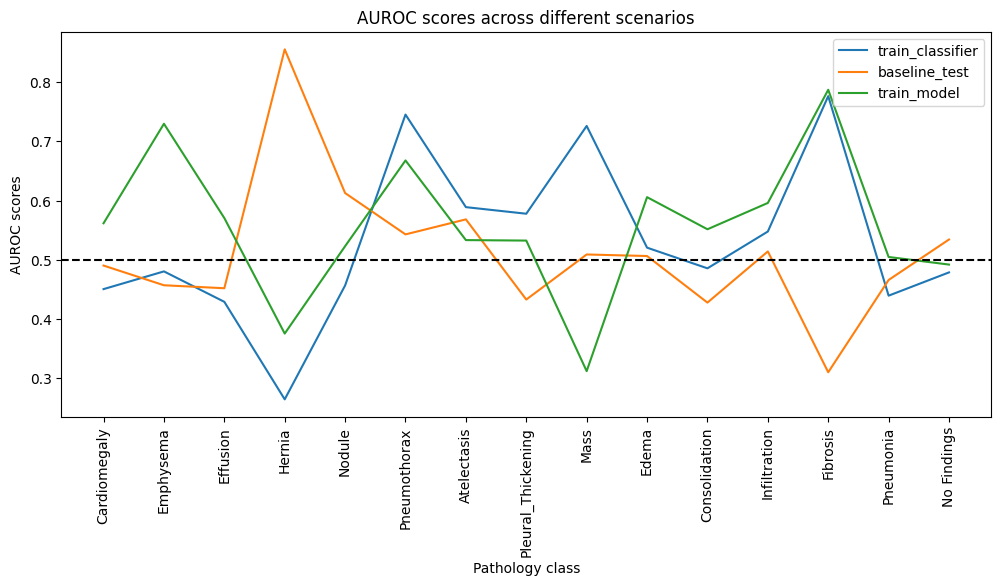

In [119]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (12,5))
for key, val in auroc_dict.items():
  plt.plot(pathology_list, val)
  plt.xticks(rotation = 90)
plt.legend(auroc_dict.keys(), loc = 'upper right')
plt.axhline(y = 0.5, color = 'black', linestyle = '--')
plt.xlabel('Pathology class')
plt.ylabel('AUROC scores')
plt.title('AUROC scores across different scenarios')
plt.show()